## Geometric Computer Vision, Skoltech, 2021 

**Alexey Artemov, Sofia Potapova**

Don't forget to turn on GPU if you want to start training directly.

## Getting started

In [ ]:
import numpy as np
import math
import random
import os

import trimesh
import torch
import scipy.spatial.distance

from utils import illustrate_mesh, illustrate_points, illustrate_camera

random.seed = 42

In [ ]:
!pip install path.py;
from path import Path


# Data

Download the dataset directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

In [ ]:
!apt-get install wget

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

In [ ]:
!unzip -q ModelNet10.zip;

In [ ]:
path = Path("ModelNet10")

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

In [ ]:
mesh = trimesh.load_mesh('./ModelNet10/chair/train/chair_0001.off')

In [ ]:
illustrate_mesh(mesh)

In [ ]:
points = mesh.vertices
illustrate_points(points, size=1.)

It would be difficult for PointNet to classify point clouds like this one. 

Let's uniformly sample some points on the surface, as we did before

In [ ]:
class PointSampler(object):
    def __init__(self, output_size=1000):
        self.output_size = output_size
    
    def __call__(self, mesh):
        sampled_points = trimesh.sample.sample_surface(mesh, self.output_size)[0]
        
        return sampled_points

In [ ]:
pointcloud = PointSampler(4000)(mesh)

illustrate_points(pointcloud, size=1.)

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        <...>

        return  pointcloud

In [ ]:
norm_pointcloud = Normalize()(pointcloud)
illustrate_points(norm_pointcloud, size=0.01)

In [ ]:
np.max(pointcloud, axis=0), np.max(norm_pointcloud, axis=0)

### Augmentations

In [ ]:
class RandRotation(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        # trimesh.transformations only theta

        <...>
        
        return  pointcloud

In [ ]:
augumented_pointcloud = RandRotation()(norm_pointcloud)
illustrate_points(augumented_pointcloud, size=0.01)

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        return torch.from_numpy(pointcloud)

In [ ]:
ToTensor()(augumented_pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([
        PointSampler(1024),
        Normalize(),
        ToTensor()
    ])

Now we can create a custom PyTorch Dataset (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


class PointCloudData(Dataset):
    def __init__(self, root_dir, is_validation=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not is_validation else default_transforms()
        self.is_validation = is_validation
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, path):
        mesh = trimesh.load_mesh(path)
        pointcloud = self.transforms(mesh)
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        pointcloud = self.__preproc__(pcd_path)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
    PointSampler(1024),
    Normalize(),
    RandRotation(),
    ToTensor()
])

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, is_validation=True, folder='test', transform=train_transforms)

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Input shape: ', train_ds[0]['pointcloud'].size())

In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [ ]:
for batch in train_loader:
    break

In [ ]:
inv_classes[int(batch['category'][0])]

In [ ]:
illustrate_points(batch['pointcloud'][0].numpy(), size=0.01)

# Point Net Model

[original_paper](#https://arxiv.org/pdf/1612.00593.pdf)

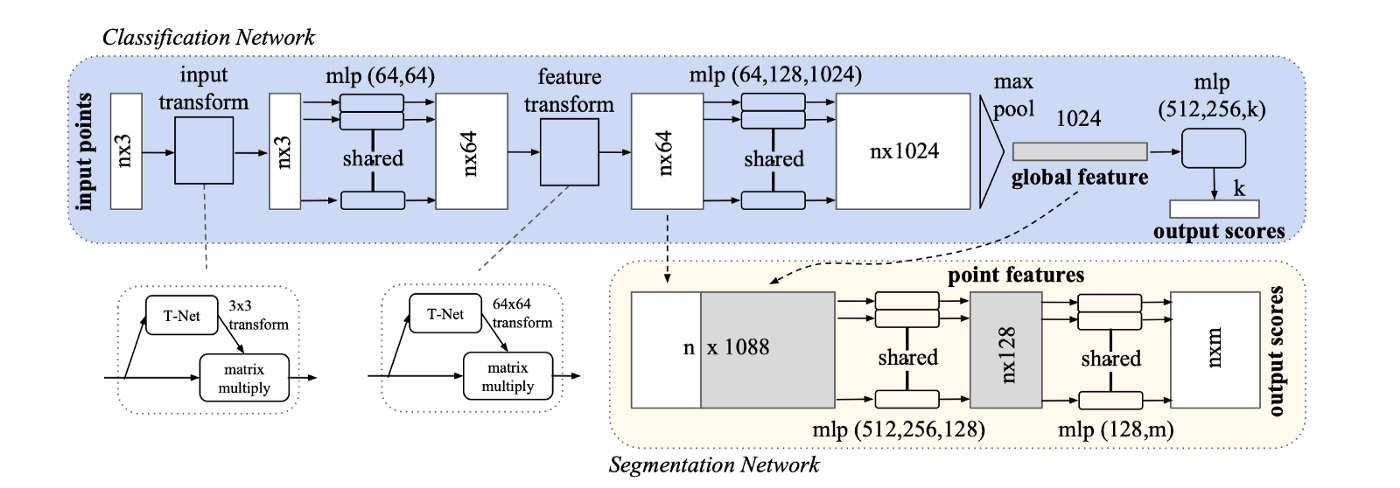

### Classification Task

In [ ]:
class PointNetClassifier(nn.Module):
    def __init__(self, classes_n=10):
        super().__init__()
        <...>
        
    def forward(self, x):
        <...>
        return logits

### Backbone

The classification network uses a shared multi-layer perceptron (MLP) to map each of the $n$ points from three dimensions $(x, y, z)$ to 64 dimensions. 

It’s important to note that a single multi-layer perceptron is shared for each of the $n$ points (i.e., mapping is identical and independent on the $n$ points). This procedure is repeated to map the $n$ points from 64 dimensions to 1024 dimensions. 

### Permutation Invariance

Given the unstructured nature of point cloud data, a scan made up of $N$ points has $N!$ permutations. The subsequent data processing must be invariant to the different representations.

In order to make PointNet invariant to input permutations, the authors turned to symmetric functions, those whose value given $n$ arguments is the same regardless of the order of the arguments (the commutative property).

$f(a, b) = f(b, a)$ # sum, average, max

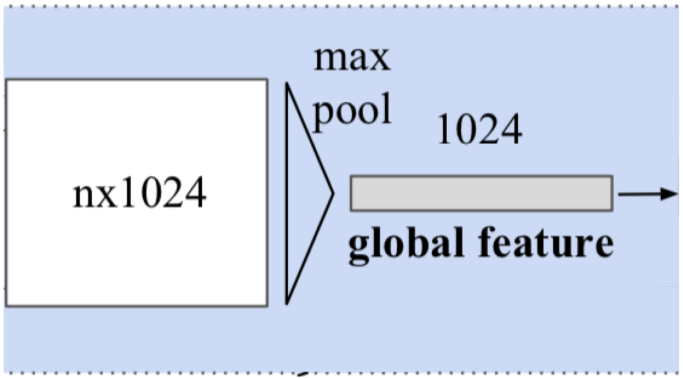

In [ ]:
class PointNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        <...>

    def forward(self, x):
        <...>
        return output

In [ ]:
model = PointNetClassifier()

In [ ]:
model.forward(inp)

### Transformation Invariance

Classification and segmentation outputs should be unchanged if the object undergoes certain transformations, including rotation and translation.


The “input transform” and “feature transform” are modular sub-networks that seek to provide pose normalization for a given input.

For a given input point cloud, apply an appropriate rigid or affine transformation to achieve pose normalization. Because each of the n input points are represented as a vector and are mapped to the embedding spaces independently, applying a geometric transformation simply amounts to matrix multiplying each point with a transformation matrix.

**T-Net** is a regression network that is tasked with predicting an input-dependent 3-by-3 transformation matrix that is then matrix multiplied with the n-by-3 input.

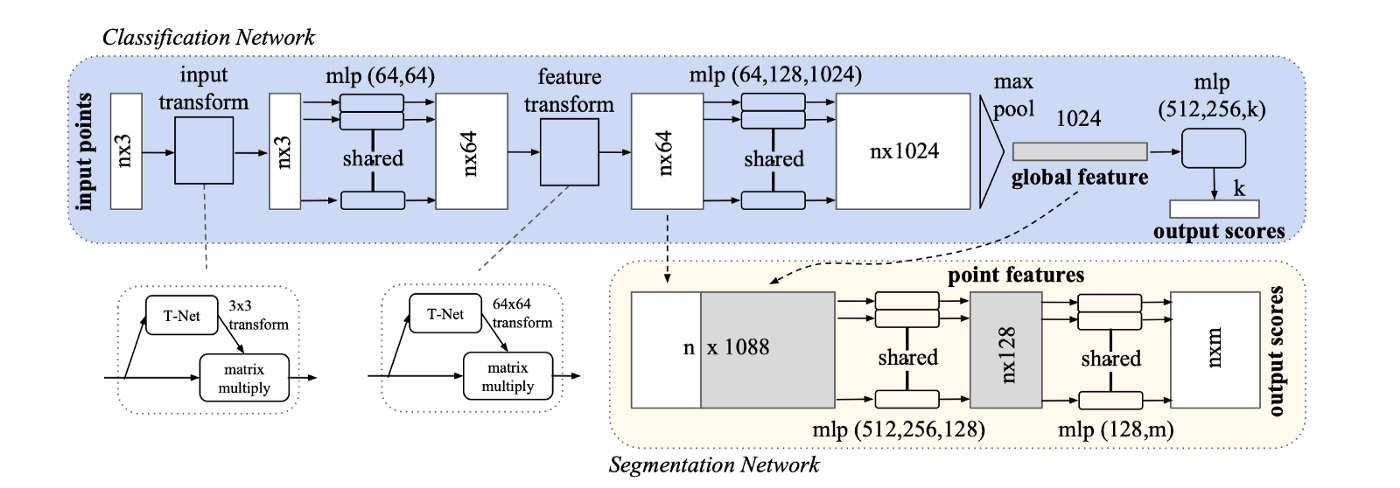

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        

    def forward(self, x):
        # x.shape == (bs,n,3)
        bs = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(x)
        
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            init = init.cuda()
        matrix = self.fc3(x).view(-1, self.k, self.k) + init
        return matrix

## Train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
pointnet = PointNetClassifier()
pointnet.to(device);

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train():
    pointnet.train()
    loss_values = []
    for i, data in enumerate(train_loader, 0):
        inputs = data['pointcloud'].to(device).float()
        labels = data['category'].to(device)

        optimizer.zero_grad()
        outputs = pointnet(inputs.transpose(1,2))

        loss = <...>
        loss.backward()
        optimizer.step()

        # print statistics
        loss_values = loss.item()
        if i % 10 == 9:
            print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                (epoch + 1, i + 1, len(train_loader), np.mean(loss_values)))
            loss_values = []


In [ ]:
def test():
    pointnet.eval()
    correct = total = 0

    for data in val_loader:
        inputs = data['pointcloud'].to(device).float()
        labels = data['category'].to(device)

        with torch.no_grad():
            outputs = pointnet(inputs.transpose(1, 2))
            _, predicted = torch.max(outputs.data, 1)
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct * 100. / total
    return accuracy

In [ ]:
for epoch in range(1, 100):
    train()
    test_acc = test()
    print('Epoch: {:03d}, Test: {:.4f}'.format(epoch, test_acc))